In [68]:
import george 
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

from tools import *
%matplotlib notebook
from glob import glob
from astropy.table import Table

from make_synmags import Spec_mags, mangle

from copy import deepcopy
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')

<IPython.core.display.Javascript object>


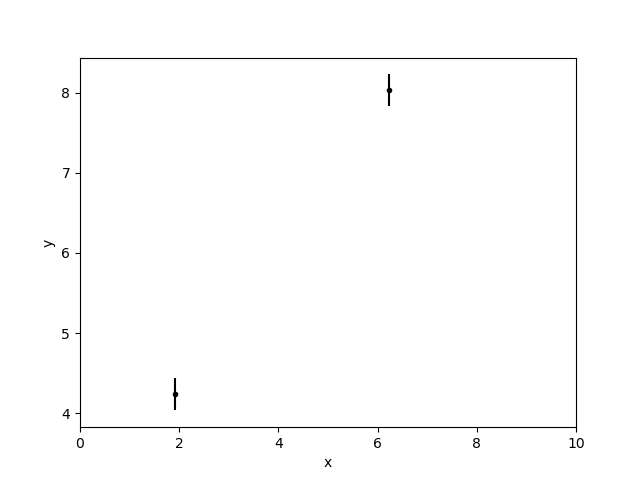

Text(0, 0.5, 'y')

In [54]:
np.random.seed(1234)
x = 10 * np.sort(np.random.rand(2))
yerr = 0.2 * np.ones_like(x)
y = 10 * np.sort(np.random.rand(2)) + yerr * np.random.randn(len(x))

plt.figure()
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlim(0, 10)
#plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y")

In [60]:
kernel = np.var(y) * george.kernels.ExpSquaredKernel(1)
gp = george.GP(kernel)
gp.compute(x)

In [61]:
x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

<IPython.core.display.Javascript object>


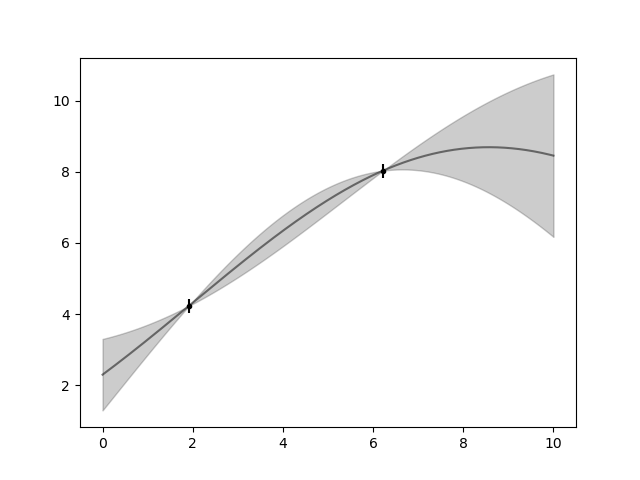

<ErrorbarContainer object of 3 artists>

In [65]:
x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.figure()
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)

In [63]:
from scipy.optimize import minimize

def neg_ln_like(p):
    print(p)
    gp.set_parameter_vector(p)
    
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

[1.2825805 0.       ]
[2.29258018e+00 7.97100146e-04]
[2.73215613e+00 1.89267104e-03]
[3.23148039 0.00389987]
[3.52877634 0.0058582 ]
[3.67721714 0.00760168]
[3.71479259 0.00881311]
[3.71850566 0.00970833]
[3.71874658 0.01058053]
[3.71971027 0.01406934]
[3.72070443 0.02248985]
[3.7246811  0.05617192]
[3.73057755 0.12833948]
[3.75416333 0.4170097 ]
[3.84850645 1.5716906 ]
[4.22587892 6.19041419]
[3.99432595 3.35639941]
[4.0792764  4.39612194]
[4.05324735 4.07754803]
[4.06239708 4.18953316]
[ 4.88987207 14.84169334]
[4.3029967  7.28679367]
[4.08871229 4.52829116]
[4.06254085 4.19138385]
[4.06253294 4.19137628]
[4.0625013  4.19134599]
[4.06237473 4.19122485]
[4.06186847 4.19074028]
[4.05984341 4.188802  ]
[4.05174319 4.1810489 ]
[4.01934231 4.15003647]
[3.92701771 4.0616014 ]
[3.70624196 3.85459019]
[3.72052695 3.87757515]
[3.71865338 3.87511505]
      fun: 5.985849976470233
 hess_inv: array([[1.68213377, 1.6260858 ],
       [1.6260858 , 4.06797503]])
      jac: array([-1.15041889e-06,  7

<IPython.core.display.Javascript object>


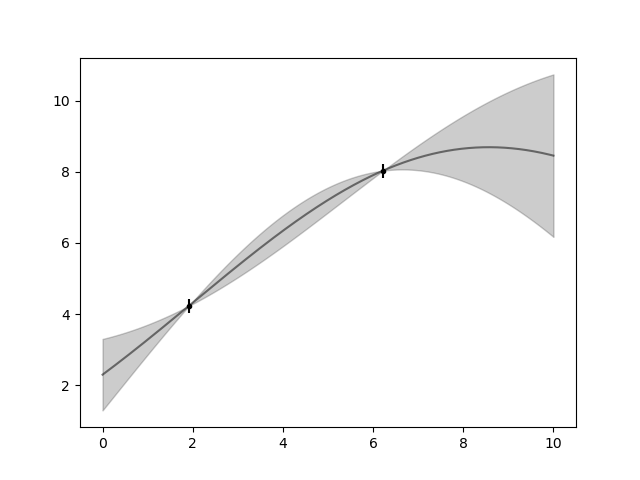

<ErrorbarContainer object of 3 artists>

In [64]:
pred, pred_var = gp.predict(y, x_pred, return_var=True)
plt.figure()
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)


# how does fitting work?

In [69]:
norm = [x['obsmode'] for x in passbands if x['passband'].startswith("Bessell/")]
norm = norm[1:]
model_mags = 0.
model = 'Vega'
norm = source_synphot.passband.load_pbs(norm, model_mags, model)

In [184]:
dat = np.loadtxt('../../data/sn/sn2011fe/11fe_snf/11feM122.dat',skiprows=1)
spec = S.ArraySpectrum(wave=dat[:,0],flux=dat[:,1],name='spec')
mags = [12.222, 12.058, 11.914, 11.873]
mags = [12.497,12.376,12.115,12.210]

In [99]:
norm

OrderedDict([('besB',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7fb414be2ed0>,
               -20.538861194488348)),
             ('besV',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7fb414c3f710>,
               -21.1143201748202)),
             ('besR',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7fb43acc30d0>,
               -21.687810590082766)),
             ('besI',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7fb414c26650>,
               -22.381803493523766))])

In [185]:
cent_wave = []
factors = []
i = 0
for key in norm:
    filt = norm[key]
    syn_mag = source_synphot.passband.synphot(spec,filt[0],zp=filt[1])
    factor = 10**(-2/5*(mags[i]-syn_mag))
    med_wav = np.average(filt[0].wave,weights = filt[0].throughput)
    cent_wave += [med_wav]
    factors += [factor]
    i += 1
cent_wave = np.array(cent_wave)
factors = np.array(factors)
#ind = np.argsort(cent_wave)
#cent_wave = cent_wave[ind]
#factors = factors[ind]

In [186]:
cent_wave

array([4413.08381985, 5512.10390774, 6471.57604955, 8059.88228212])

<IPython.core.display.Javascript object>


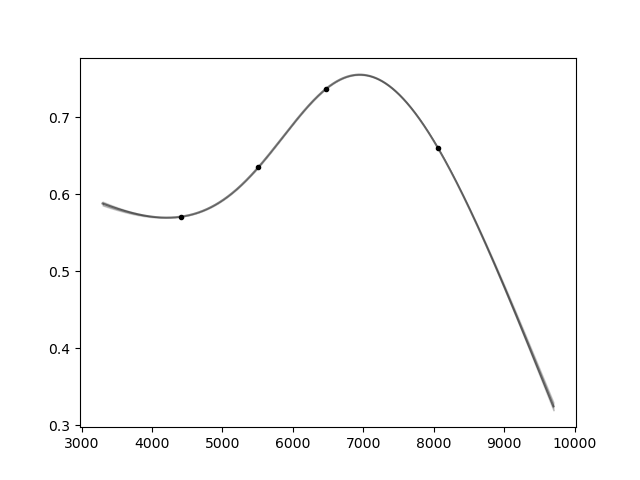

<ErrorbarContainer object of 3 artists>

In [187]:
#kernel = np.var(factors) * george.kernels.Matern52Kernel(1)
k1 = np.var(factors) * george.kernels.Matern32Kernel(1)
k2 = np.var(factors) * george.kernels.Matern52Kernel(1)
kernal = k1 + k2
gp = george.GP(kernel)
gp.compute(cent_wave)

x_pred = spec.wave.copy()
pred, pred_var = gp.predict(factors, x_pred, return_var=True)

plt.figure()
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(cent_wave, factors, fmt=".k", capsize=0)

In [188]:
def fit_mags(p,pbs,spec,mags):
    gp.set_parameter_vector(p)
    x_pred = spec.wave.copy()
    pred, pred_var = gp.predict(factors, x_pred, return_var=True)
    res = 0
    i = 0
    s = S.ArraySpectrum(wave=spec.wave,flux=spec.flux*pred)
    for key in pbs:
        filt = pbs[key]
        syn_mag = source_synphot.passband.synphot(s,filt[0],zp=filt[1])
        res += (syn_mag-mags[i])
        i += 1
    print(res)
    return res

In [189]:
def neg_ln_like(p):
    print(p)
    gp.set_parameter_vector(p)
    
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(fit_mags, gp.get_parameter_vector(),args=(norm,spec,mags))

0.04155012131800362
0.041550121317854405
0.041550121367919246
0.04153884535389096
0.04153884535396912
0.0415388454040837
0.04149386742665939
0.041493867426609654
0.04149386747653949
0.04131610196470348
0.04131610196478874
0.041316102013766454
0.040648448266054515
0.0406484482661682
0.04064844830964631
0.0394294984222654
0.0394294984222654
0.039429498431978516
0.03940622227809598
0.03940622227809598
0.03940622227171531
0.0393921794289156
0.039392179428887175
0.03939217942928508
0.03939212265822789
0.039392122658220785
0.03939212265826342


In [149]:
result

      fun: 0.027763987065805296
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([-1.90734863e-06, -7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([-5.4687668 , 18.27443836])

<IPython.core.display.Javascript object>


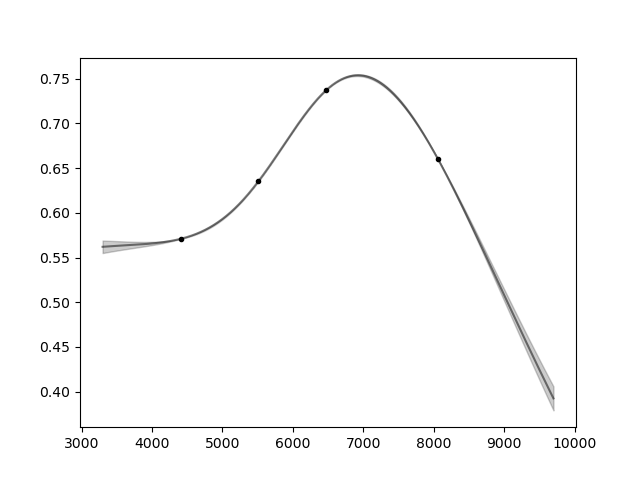

<ErrorbarContainer object of 3 artists>

In [190]:
pred, pred_var = gp.predict(factors, x_pred, return_var=True)

plt.figure()
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(cent_wave, factors, fmt=".k", capsize=0)

In [193]:
pred, pred_var = gp.predict(factors, x_pred, return_var=True)
s = S.ArraySpectrum(wave=spec.wave,flux=spec.flux*pred)

<IPython.core.display.Javascript object>


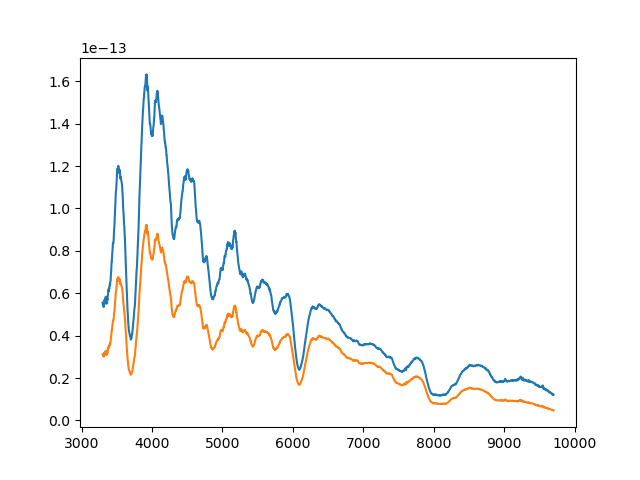

In [194]:
plt.figure()
plt.plot(spec.wave,spec.flux)
plt.plot(s.wave,s.flux)

In [195]:
i = 0
for key in norm:
    filt = norm[key]
    syn_mag = source_synphot.passband.synphot(s,filt[0],zp=filt[1])
    print(syn_mag-mags[i])
    i += 0

-0.0037055025713570444
-0.11970623072331676
-0.3504114162998384
-0.2767847277472235


In [144]:
np.log(0.9715438767024934)

-0.02886884731162905

In [160]:
from scipy.interpolate import CubicSpline

from scipy.interpolate import splprep, splev

In [162]:
tck, u = splprep([cent_wave, factors], s=0)
new_points = splev(u, tck)

In [163]:
new_points

[array([4413.08381985, 5512.10390774, 6471.57604955, 8059.88228212]),
 array([0.73561814, 0.85165362, 0.88712206, 0.9006356 ])]

In [158]:
spline = CubicSpline(cent_wave,factors,extrapolate=True,bc_type='clamped')

<IPython.core.display.Javascript object>


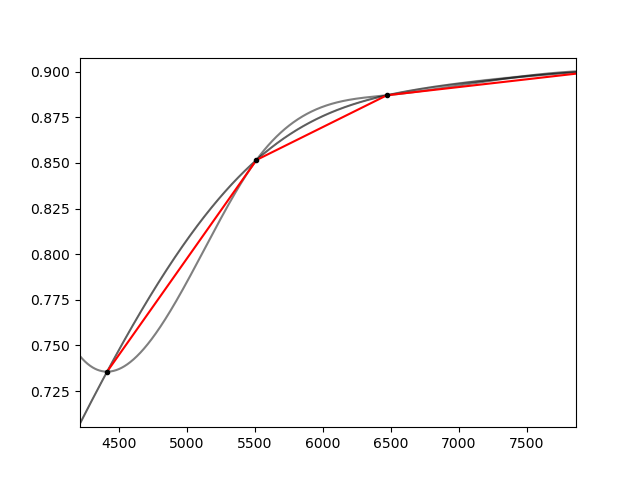

In [164]:
pred, pred_var = gp.predict(factors, x_pred, return_var=True)

plt.figure()
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.plot(x_pred, spline(x_pred), "k", lw=1.5, alpha=0.5)
plt.errorbar(cent_wave, factors, fmt=".k", capsize=0)
plt.plot(new_points[0], new_points[1], 'r-')

# try simple case again

In [196]:
scale = np.array((spec.wave,spec.flux))
scale[1,:] = 1
i = 0
inds = []
for pb in norm:
    filt = norm[pb]
    syn_mag = source_synphot.passband.synphot(spec,filt[0],zp=filt[1])
    factor = 10**(-2/5*(mags[i]-syn_mag))
    med_wav = np.average(filt[0].wave,weights = filt[0].throughput)
    ind = np.argmin(abs(scale[0,:] - med_wav))
    inds += [ind]
    scale[1,ind] = factor
    i += 1 
inds.sort()
# Scipy interpolation, more flexibility in fit
#interp = interp1d(scale[0,inds],scale[1,inds],kind='linear',bounds_error=False,fill_value=0)
#interped = interp(scale[0,:])
#interped[:min(inds)] = scale[1,min(inds)]
#interped[:max(inds)] = scale[1,max(inds)]

factors = np.interp(scale[0,:],scale[0,inds],scale[1,inds])
scale[1,:] = factors
s = S.ArraySpectrum(spec.wave,spec.flux*scale[1,:])

In [200]:
def fit_factors(factors,cent_wave,pbs,spec,mags):
    scale = np.interp(spec.wave,cent_wave,factors,left=factors[0],right=factors[-1])
    res = 0
    i = 0
    s = S.ArraySpectrum(wave=spec.wave,flux=spec.flux*scale)
    for key in pbs:
        filt = pbs[key]
        syn_mag = source_synphot.passband.synphot(s,filt[0],zp=filt[1])
        res += abs(syn_mag-mags[i])
        i += 1
    return res

In [201]:
cent_wave = []
factors = []
i = 0
for key in norm:
    filt = norm[key]
    syn_mag = source_synphot.passband.synphot(spec,filt[0],zp=filt[1])
    factor = 10**(-2/5*(mags[i]-syn_mag))
    med_wav = np.average(filt[0].wave,weights = filt[0].throughput)
    cent_wave += [med_wav]
    factors += [factor]
    i += 1
cent_wave = np.array(cent_wave)
factors = np.array(factors)

In [202]:
result = minimize(fit_factors, factors,args=(cent_wave,norm,spec,mags), method="Nelder-Mead")


In [203]:
result

 final_simplex: (array([[0.56493774, 0.61980777, 0.80676234, 0.63590309],
       [0.56492275, 0.61978086, 0.80679245, 0.63588856],
       [0.56489996, 0.61988492, 0.80667052, 0.63593438],
       [0.56492405, 0.61980172, 0.80674684, 0.63586438],
       [0.56492744, 0.61982862, 0.80676168, 0.63586407]]), array([9.31198229e-05, 1.20834101e-04, 1.21830034e-04, 1.32195247e-04,
       1.47257038e-04]))
           fun: 9.31198229245922e-05
       message: 'Optimization terminated successfully.'
          nfev: 130
           nit: 73
        status: 0
       success: True
             x: array([0.56493774, 0.61980777, 0.80676234, 0.63590309])

In [204]:
scale = np.interp(spec.wave,cent_wave,factors,left=factors[0],right=factors[-1])
res = 0
i = 0
s = S.ArraySpectrum(wave=spec.wave,flux=spec.flux*scale)
for key in norm:
    filt = norm[key]
    syn_mag = source_synphot.passband.synphot(s,filt[0],zp=filt[1])
    print(abs(syn_mag-mags[i]))

0.013564795141867592
0.12682211612421668
0.3284557956468639
0.3049074438538746


In [205]:
mags

[12.497, 12.376, 12.115, 12.21]